In [4]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df_train = pd.read_csv('train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
#Create Validation Set
df_valid = pd.read_csv('test.csv')
df_gender = pd.read_csv('gender_submission.csv')

df_valid = pd.merge(df_valid, df_gender, on='PassengerId')
df_valid.dropna(subset=['Survived'], inplace=True)
df_valid.dropna(subset=['Fare'], inplace=True)

df_valid.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [8]:
def manual_preprocess_df(df):
    df = df.drop(['Name', 'PassengerId', 'Cabin', 'Ticket'], axis = 1)
    df['Embarked'] = df['Embarked'].map({
        'C' : 0,
        'Q' : 1,
        'S' : 2
    })
    df['Sex'] = df['Sex'].map({
        'male' : 0,
        'female' : 1
    })
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df.dropna(subset=['Embarked'], inplace=True)
    return df

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
df_train = manual_preprocess_df(df_train)
df_valid = manual_preprocess_df(df_valid)

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,2.0
1,1,1,1,38.0,1,0,71.2833,0.0
2,1,3,1,26.0,0,0,7.9250,2.0
3,1,1,1,35.0,1,0,53.1000,2.0
4,0,3,0,35.0,0,0,8.0500,2.0


In [11]:
#Label - Data Splits
def label_data_split(df):
    y = df['Survived']
    x = df.loc[:, df.columns != 'Survived']
    return (x,y)

In [12]:
#Train - Test Split & Shuffling
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

df_train = shuffle(df_train)

(labels, targets) = label_data_split(df_train)

x_train, x_test, y_train, y_test = train_test_split(labels, targets, test_size=0.33)

In [13]:
#Scaler
from sklearn.preprocessing import StandardScaler

D = 7

dataScaler = StandardScaler()

x_train = dataScaler.fit_transform(x_train)
x_test = dataScaler.transform(x_test)

In [14]:
#Build Model With TF Keras Functional API
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, LSTM
from tensorflow.keras.models import Model

i = Input(shape=(D,1))
x = LSTM(32, return_sequences=True, activation=LeakyReLU(alpha=0.2))(i)
x = Dropout(0.2)(x)
x = LSTM(64, return_sequences=True, activation=LeakyReLU(alpha=0.3))(x)
x = Dropout(0.2)(x)
x = LSTM(128, activation=LeakyReLU(alpha=0.3))(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i,x)

In [15]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(
        learning_rate=0.0011
    ),
    metrics = ['accuracy']
)

In [16]:
#Early Stop For Val_Accuracy
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=15)

In [17]:
r = model.fit(
    x_train,
    y_train,
    validation_data=(x_test,y_test),
    epochs = 150,
    callbacks=[early_stop]
)

Epoch 1/150
19/19 [==============================] - 8s 62ms/step - loss: 0.6857 - accuracy: 0.5882 - val_loss: 0.6580 - val_accuracy: 0.6599
Epoch 2/150
19/19 [==============================] - 1s 35ms/step - loss: 0.6767 - accuracy: 0.5966 - val_loss: 0.6415 - val_accuracy: 0.6599
Epoch 3/150
19/19 [==============================] - 1s 43ms/step - loss: 0.6696 - accuracy: 0.5966 - val_loss: 0.6429 - val_accuracy: 0.6599
Epoch 4/150
19/19 [==============================] - 1s 65ms/step - loss: 0.6654 - accuracy: 0.5950 - val_loss: 0.6215 - val_accuracy: 0.6531
Epoch 5/150
19/19 [==============================] - 1s 63ms/step - loss: 0.6466 - accuracy: 0.5882 - val_loss: 0.6168 - val_accuracy: 0.6293
Epoch 6/150
19/19 [==============================] - 1s 36ms/step - loss: 0.6299 - accuracy: 0.5966 - val_loss: 0.6006 - val_accuracy: 0.6939
Epoch 7/150
19/19 [==============================] - 1s 33ms/step - loss: 0.6108 - accuracy: 0.6504 - val_loss: 0.5642 - val_accuracy: 0.7211
Epoch 

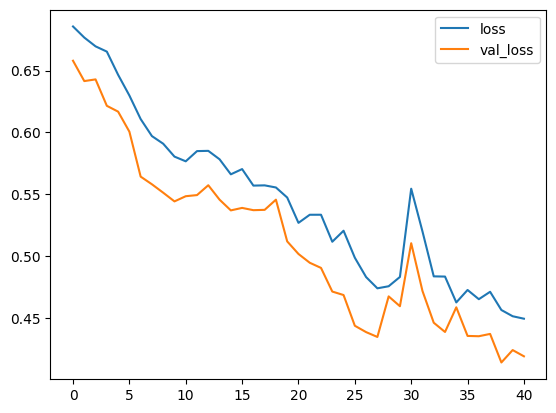

In [18]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')

plt.legend()

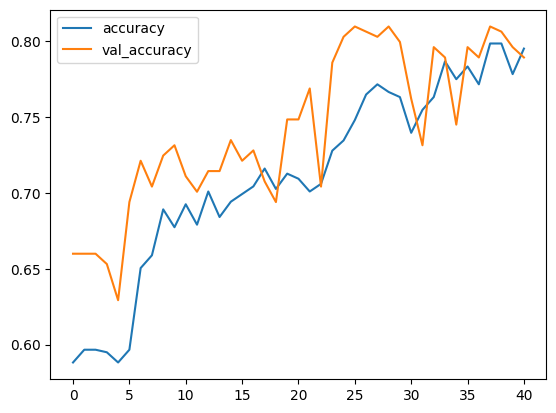

In [19]:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')

plt.legend()

In [20]:
#Evaluate Split Train Data
split_evals = model.evaluate(
    x_test,
    y_test
)

10/10 [==============================] - 0s 14ms/step - loss: 0.4189 - accuracy: 0.7891


In [21]:
#Evaluate with merged submission sample
(x_valid, y_valid) = label_data_split(df_valid)

x_valid = dataScaler.transform(x_valid)

merged_evals = model.evaluate(
    x_valid,
    y_valid
)

14/14 [==============================] - 0s 16ms/step - loss: 0.3231 - accuracy: 0.9185


<BarContainer object of 4 artists>

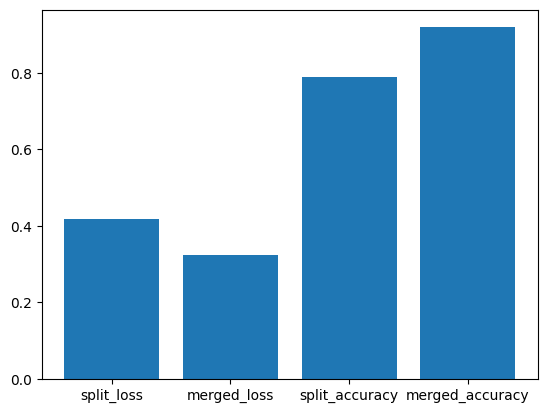

In [22]:
labels = ["split_loss", "merged_loss", "split_accuracy", "merged_accuracy"]
values = [split_evals[0], merged_evals[0], split_evals[1], merged_evals[1]]

plt.bar(labels, values)

In [23]:
prediction_df = pd.read_csv('test.csv')

prediction_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [39]:
prediction_df_processed = manual_preprocess_df(prediction_df)

prediction_df_processed.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,0,34.5,0,0,7.8292,1,0
1,3,1,47.0,1,0,7.0000,2,1
2,2,0,62.0,0,0,9.6875,1,1
3,3,0,27.0,0,0,8.6625,2,0
4,3,1,22.0,1,1,12.2875,2,1


In [25]:
prediction_df_processed['Fare'] = prediction_df_processed['Fare'].fillna(prediction_df_processed['Fare'].mean())

In [26]:
x_prediction = dataScaler.transform(prediction_df_processed)

In [27]:
predictions = model.predict(
    x_prediction
)

14/14 [==============================] - 1s 8ms/step


In [56]:
test_data = prediction_df["Survived"].to_numpy()


(418,)

In [59]:
predictions_flat = predictions.flatten()


(418,)

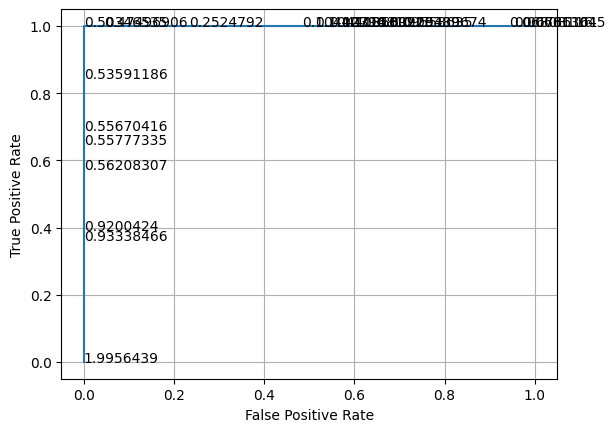

In [71]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fp, tp, threshold = roc_curve(test_data, predictions_flat)
plt.plot(fp,tp)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
skip = 2

for i in range(0,len(threshold),skip):
  plt.text(fp[i],tp[i],threshold[i])

plt.grid()
plt.show()


[[244   0]
 [  0 174]]


<Axes: >

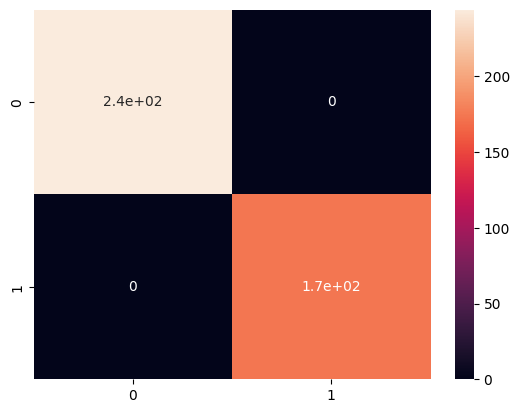

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
threshold = 0.5
cm = confusion_matrix(test_data,predictions > threshold)
print(cm)
sns.heatmap(cm, annot=True)


In [79]:
from sklearn.metrics import f1_score
score = f1_score(test_data,predictions > threshold)
score

1.0

In [80]:
result_df = pd.DataFrame(prediction_df)
result_df['Survived'] = predictions
result_df['Survived'] = result_df['Survived'].apply(lambda x: 1 if x > threshold else 0)


result_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [30]:
# prompt: predict as menual data by user
# Enter your details here
gender = 'female'
age = 38
fare = 71.2833
embarked = 'C'

# Convert categorical data to numerical values
gender = 0 if gender.lower() == 'male' else 1
embarked = {'C': 0, 'Q': 1, 'S': 2}.get(embarked.upper(), -1)

# Check if embarked is valid
if embarked == -1:
    print("Invalid 'embarked' value. Please use 'C', 'Q', or 'S'.")
    exit()

# Create a list of passenger data
passenger = [1, gender, age, 1, 0, fare, embarked]  # Assuming Pclass=1 for simplicity

# Reshape the list into a NumPy array
passenger = np.array(passenger).reshape(1, -1)

# Scale the passenger data using the same scaler used during training
passenger = dataScaler.transform(passenger)

# Make a prediction
prediction = model.predict(passenger)

# Print the prediction
print("Survival Probability:", prediction[0, 0])


1/1 [==============================] - 0s 67ms/step
Survival Probability: 0.9945996


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [31]:
# prompt: save model to json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)



In [32]:
model.save("my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
# pip install tensorflowjs

In [34]:
import tensorflowjs as tfjs

# Assume that you have a compiled Keras model named 'model'
tfjs.converters.save_keras_model(model, '../Model')

ModuleNotFoundError: No module named 'tensorflowjs'

In [ ]:
import json
# Save the scaler information
scaler_info = {
    'mean': dataScaler.mean_.tolist(),
    'scale': dataScaler.scale_.tolist()
}
with open("scaler_info.json", "w") as json_file:
    json.dump(scaler_info, json_file)

In [ ]:
# prompt: use the saved model to predict the data that get from user

# Enter your details here
gender = 'female'
age = 38
fare = 71.2833
embarked = 'C'

# Convert categorical data to numerical values
gender = 0 if gender.lower() == 'male' else 1
embarked = {'C': 0, 'Q': 1, 'S': 2}.get(embarked.upper(), -1)

# Check if embarked is valid
if embarked == -1:
    print("Invalid 'embarked' value. Please use 'C', 'Q', or 'S'.")
    exit()

# Create a list of passenger data
passenger = [1, gender, age, 1, 0, fare, embarked]  # Assuming Pclass=1 for simplicity

# Reshape the list into a NumPy array
passenger = np.array(passenger).reshape(1, -1)

# Scale the passenger data using the same scaler used during training
passenger = dataScaler.transform(passenger)

# Make a prediction
prediction = model.predict(passenger)

# Print the prediction
print("Survival Probability:", prediction[0, 0])
